In [11]:
import datasets
import torch
import numpy as np
import json
import pickle
from tqdm import tqdm

from datasets.dataset_dict import DatasetDict

## Get negation indices

In [4]:
data_path = "/home/meissner/shortcut-pruning/data/fever/"

In [28]:
fever_train = datasets.load_dataset("json", data_files=data_path + "fever_train.jsonl")["train"].rename_column("gold_label", "label")
fever_val = datasets.load_dataset("json", data_files=data_path + "fever_dev.jsonl")["train"].rename_column("gold_label", "label")
fever_symm = datasets.load_dataset("json", data_files=data_path + "fever_symmetric_full.jsonl")[
    "train"
]
dataset = DatasetDict({"train" : fever_train, "val": fever_val, "test" : fever_symm})

Using custom data configuration default-636923bdd33586c5
Reusing dataset json (/home/meissner/.cache/huggingface/datasets/json/default-636923bdd33586c5/0.0.0/c90812beea906fcffe0d5e3bb9eba909a80a998b5f88e9f8acbd320aa91acfde)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-23ebb10018d3e881
Reusing dataset json (/home/meissner/.cache/huggingface/datasets/json/default-23ebb10018d3e881/0.0.0/c90812beea906fcffe0d5e3bb9eba909a80a998b5f88e9f8acbd320aa91acfde)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-ae9f4254e2d8cee5
Reusing dataset json (/home/meissner/.cache/huggingface/datasets/json/default-ae9f4254e2d8cee5/0.0.0/c90812beea906fcffe0d5e3bb9eba909a80a998b5f88e9f8acbd320aa91acfde)


  0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
dataset['train']

Dataset({
    features: ['label', 'evidence', 'claim', 'id', 'weight'],
    num_rows: 242911
})

In [25]:
dataset['test']

Dataset({
    features: ['id', 'label', 'claim', 'evidence_sentence'],
    num_rows: 956
})

In [7]:
negation_words = [" no ", " not ", " don't ", " none ", " nothing ", 
                  " never ", " aren’t ", " isn’t ", " weren’t ", 
                  " neither ", " don’t ", " didn’t ", " doesn’t ", 
                  " cannot ", " hasn’t ", " won’t "]

In [78]:
def find_negation_idxs(dataset):
    ent_indices, cont_indices = [], []
    for idx,sample in enumerate(dataset):
        if any([word in sample["claim"].lower() for word in negation_words]):
            if sample['label'] == "SUPPORTS":
                ent_indices.append(idx)
            elif sample['label'] == "REFUTES":
                cont_indices.append(idx)
    return ent_indices, cont_indices

In [79]:
train_ents, train_conts = find_negation_idxs(dataset["train"])
val_ents, val_conts = find_negation_idxs(dataset["val"])
test_ents, test_conts = find_negation_idxs(dataset["test"])

In [80]:
list(map(len, [train_ents, train_conts, val_ents, val_conts, test_ents, test_conts]))

[908, 6505, 61, 865, 38, 38]

In [81]:
fever_neg_indices = {"val_supports" : val_ents, "val_refutes" : val_conts, "test_supports" : test_ents, "test_refutes" : test_conts}

In [82]:
with open("/home/meissner/shortcut-pruning/data/subsets/fever_negation_indices.json", "w") as _file:
    _file.write(json.dumps(fever_neg_indices))

In [83]:
for key, value in fever_neg_indices.items():
    print(key)
    print(len(value))

val_supports
61
val_refutes
865
test_supports
38
test_refutes
38


## Lexical Overlap

In [34]:
import nltk
import string
from nltk.tokenize import word_tokenize

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/meissner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
puncts = set(string.punctuation)
print(puncts)

{'&', '?', '{', '#', '`', '%', '+', '!', '*', '~', ',', '|', ':', '_', '=', ')', '^', '/', '"', '<', '}', '[', '(', ']', '>', '$', '.', '@', '-', '\\', "'", ';'}


In [37]:
def jaccard_similarity(set1, set2):
    return float(len(set1.intersection(set2)) / len(set1.union(set2)))

In [38]:
word_tokenize(dataset['val'][23]['claim'])

['Ann', 'Richards', 'was', 'professionally', 'involved', 'in', 'politics', '.']

In [39]:
jaccards = []
for sample in dataset['val']:
    hyposet = set(word_tokenize(sample['claim'].lower())) - puncts
    premset = set(word_tokenize(sample['evidence'].lower())) - puncts
    jaccards.append(jaccard_similarity(hyposet, premset))
jaccards = np.array(jaccards)

In [40]:
np.min(jaccards), np.mean(jaccards), np.max(jaccards), np.argmax(jaccards), np.argmin(jaccards)

(0.0, 0.17720436684426374, 1.0, 5477, 19)

In [41]:
from matplotlib import pyplot as plt

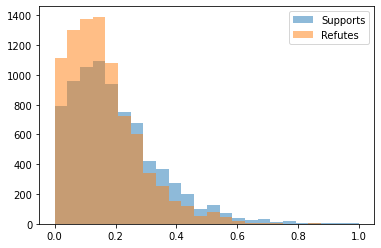

In [44]:
bins = np.linspace(0.0, 1.0, 25)
labels = np.array(dataset['val']['label'])
ent_jaccards = jaccards[labels == "SUPPORTS"]
cont_jaccards = jaccards[labels == "REFUTES"]
plt.hist(ent_jaccards, bins, alpha=0.5, label="Supports")
plt.hist(cont_jaccards, bins, alpha=0.5, label="Refutes")
plt.legend()
plt.show()

In [45]:
len(labels)

16664

In [49]:
top_indices = np.argsort(jaccards)[-500:]

In [50]:
jaccards[top_indices[0]] # Cut rate

0.5

In [51]:
np.mean(labels[top_indices] == "SUPPORTS") # 

0.67

In [61]:
# top_samples = dataset['val'].select(top_indices)
top_labels = labels[top_indices]

In [68]:
top_refutes_indices = np.argwhere(top_labels == 'REFUTES')
top_supports_indices = np.argwhere(top_labels == 'SUPPORTS')

In [69]:
assert len(top_indices) == len(top_supports_indices) + len(top_refutes_indices)

In [70]:
fever_dev_indices = {"val_supports" : top_supports_indices, "val_refutes" : top_refutes_indices}

In [71]:
import numpy
import json

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.integer):
            return int(obj)
        elif isinstance(obj, numpy.floating):
            return float(obj)
        elif isinstance(obj, numpy.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [72]:
with open("/home/meissner/shortcut-pruning/data/subsets/fever_lex_overlap_indices.json", "w") as _file:
    _file.write(json.dumps(fever_dev_indices, cls=MyEncoder))

--------------------------------------------------------

In [13]:
def find_high_lex_overlap_idxs(dataset, count_lim=400):
    jaccards = []
    labels = np.array(dataset['label'])
    for sample in dataset:
        hyposet = set(word_tokenize(sample['hypothesis'].lower())) - puncts
        premset = set(word_tokenize(sample['premise'].lower())) - puncts
        jaccards.append(jaccard_similarity(hyposet, premset))
    jaccards = np.array(jaccards)
    top_indices = np.argsort(jaccards)[-count_lim:]
    ent_indices = top_indices[labels[top_indices] == 0]
    cont_indices = top_indices[labels[top_indices] == 2]
    return ent_indices, cont_indices

In [14]:
# train_ents, train_conts = find_high_lex_overlap_idxs(mnli["train"], count_lim=4000)
val_m_ents, val_m_conts = find_high_lex_overlap_idxs(mnli["validation_matched"], count_lim=200)
val_mm_ents, val_mm_conts = find_high_lex_overlap_idxs(mnli["validation_mismatched"], count_lim=200)

In [26]:
val_m_ents[0]

3262

In [27]:
mnli['validation_matched'][int(val_m_ents[0])], mnli['validation_matched'][int(val_m_conts[0])]

({'premise': 'Shoot only the ones that face us, Jon had told Adrin.',
  'hypothesis': 'Jon instructed Adrin to only shoot the ones that face us.',
  'label': 0,
  'idx': 3262},
 {'premise': 'The rain had stopped, but the green glow painted everything around them.',
  'hypothesis': 'The red glow painted everything around them after the rain had stopped.',
  'label': 2,
  'idx': 8901})

In [28]:
all_indices = {"train_ents" : list(train_ents), "train_conts" : list(train_conts), "val_m_ents" : list(val_m_ents), "val_m_conts" : list(val_m_conts), "val_mm_ents" : list(val_mm_ents), "val_mm_conts" : list(val_mm_conts)}

In [29]:
for key, value in all_indices.items():
    print(key)
    print(len(value))

train_ents
3179
train_conts
504
val_m_ents
144
val_m_conts
36
val_mm_ents
144
val_mm_conts
28


In [30]:
type(all_indices['val_m_ents'][0])

numpy.int64

In [31]:
import numpy
import json

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.integer):
            return int(obj)
        elif isinstance(obj, numpy.floating):
            return float(obj)
        elif isinstance(obj, numpy.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [32]:
with open("/home/meissner/shortcut-pruning/data/subsets/mnli_lex_overlap_indices.json", "w") as _file:
    _file.write(json.dumps(all_indices, cls=MyEncoder))

## Negation without lexical overlap

In [39]:
val_negs = all_neg_indices["val_m_ents"]

In [40]:
val_neg_ent_samples = mnli['validation_matched'].select(val_negs)

In [41]:
top_ent_arr, top_cont_arr = find_high_lex_overlap_idxs(val_neg_ent_samples, count_lim=0)

In [31]:
top_ent_arr

array([284,  87, 186, 150, 471, 466, 595, 553, 274, 318,   3,   1, 567,
       465, 242, 425, 478, 299, 387, 126, 199, 217, 569, 128, 346, 434,
       428, 545, 506, 502, 234, 246, 268, 243, 447, 120, 556,  63, 517,
       539, 152, 170, 207, 280, 245, 116, 522, 562, 123, 139, 205, 203,
       481, 554, 140, 297, 563, 163, 173, 209, 108, 578, 180, 586, 229,
       571,  17, 546, 550, 508, 467, 371, 518, 175, 459, 415,  45, 135,
       394, 104, 480, 392,  97, 399, 412, 460, 379, 505,  67, 233, 343,
       498, 538, 141,  53, 212, 112,  41, 368, 252, 166, 362, 125, 489,
       106, 319, 367, 220, 321, 192, 335,  92, 581, 464, 155, 390, 598,
       285, 499, 194, 329, 105, 408, 317,  78, 584, 146, 406, 475, 528,
       336, 202, 369, 386, 440, 495,  66, 544, 560, 168,  39, 215, 491,
       119, 383, 332, 345, 354, 124, 353, 342, 366, 527, 130,  19, 298,
       521,  76, 174, 444, 303, 251,  70,  14, 576, 441,  20,  81,  30,
       237, 497, 501, 289, 219, 402, 277, 424,  62, 312, 283, 48

In [42]:
len(val_negs), len(top_ent_arr), len(top_cont_arr)

(319, 319, 0)

In [43]:
val_negs[top_ent_arr[-1]]

4052

In [48]:
for i in top_ent_arr[:5]:
    print(mnli['validation_matched'][val_negs[i]])

{'premise': 'In short, most of the whale is incompressible.', 'hypothesis': 'Whales cannot be compressed well.', 'label': 0, 'idx': 1445}
{'premise': "Several of its beaches are officially designated for nudism (known locally as naturisme) the most popular being Pointe Tarare and a functionary who is a Chevalier de la L??gion d'Honneur has been appointed to supervise all aspects of sunning in the buff.", 'hypothesis': 'They do not mind having nude people.', 'label': 0, 'idx': 2517}
{'premise': 'Normally, these discussions are kept secret.', 'hypothesis': 'In usual circumstances, what is said is not to be shared..', 'label': 0, 'idx': 7252}
{'premise': 'Others watched them with cold eyes and expressionless faces.', 'hypothesis': 'Some people who were not emotive were watching.', 'label': 0, 'idx': 4671}
{'premise': 'Even though national saving remains relatively low by U.S. historical standards, economic growth in recent years has been high because more and better investments were made.

In [44]:
mnli['validation_matched'][4052]

{'premise': 'Part of the reason for the difference in pieces per possible delivery may be due to the fact that five percent of possible residential deliveries are businesses, and it is thought, but not known, that a lesser percentage of possible deliveries on rural routes are businesses.',
 'hypothesis': 'It is thought, but not known, that a lesser percentage of possible deliveries on rural routes are businesses, and part of the reason for the difference in pieces per possible delivery, may be due to the fact that five percent of possible residential deliveries are businesses.',
 'label': 0,
 'idx': 4052}

In [53]:
type(val_negs[0])

int

In [54]:
neg_ent_new_indices = [val_negs[i] for i in top_ent_arr[:50]] 

In [55]:
with open("/home/meissner/shortcut-pruning/data/subsets/mnli_neg_ent_new2.json", "w") as _file:
    _file.write(json.dumps(neg_ent_new_indices))